In [314]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math

In [315]:
source = 'results'
verbose = False

In [327]:
# Loop through tests, loading results into lists of dictionaries
tests = ['test1', 'test2', 'test3', 'test4']
tests_short = ['Test 1', 'Test 2', 'Test 3', 'Test 4']

detection_models = ['ssd_mobilenet_v2_coco',
          'faster_rcnn_resnet101_coco']

detection_models_short = ['ssd_mobilenet_v2',
                          'f_rcnn_resnet101']

odms = ['OD1', 'OD2']

association_models = ['pixel_feature_matching', 'complex_feature_matching']

oams = ['OA1', 'OA2']

comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']

In [317]:
# calc num individuals
def get_track_results(results, verbose=False):
    IDs = []
    for line in results:
        IDs.append(int(line[1]))
    uniques = set(IDs)
    num_uniques = len(uniques)
    if verbose:
        print('Unique ids: {}'.format(num_uniques))

    # calc frames per unique
    unique_frame_counts = []
    for unique in uniques:
        frame_count = 0
        for line in results:
            if int(line[1]) == unique:
                frame_count += 1
        unique_frame_counts.append(frame_count)

    average_unique_frame_counts = sum(unique_frame_counts) / len(uniques)
    if verbose:
        print('Average frames per id: {}'.format(average_unique_frame_counts))
    
    return num_uniques, average_unique_frame_counts
    

In [318]:
# test extract results
detection_model = detection_models[0]
association_model = association_models[0]
test = tests[0]

path = os.path.join(source, 'tracker_' + test + '_2018-08-10_' + detection_model + '__' + association_model)
results_path = os.path.join(path, '2015-01-03.npy')

results = np.load(results_path)
if verbose:
    print('\t\t> {} detections'.format(len(model_results)))


In [319]:
get_track_results(results)

(8, 3.25)

In [320]:
# extract GTs
gts = {}
for test in tests:
    gt_path = os.path.join('MOT', 'test', test, 'gt', 'gt.csv')
    with open(gt_path, 'r') as f:
      reader = csv.reader(f)
      gt_raw = list(reader)
    
    gt = []
    for result in gt_raw:
        if not int(result[1]) == -1:
            gt.append(result)
    gt_array = np.array(gt)

    gts[test] = gt_array.astype('float')

In [321]:
get_track_results(gts['test4'])

(342, 3.426900584795322)

In [322]:
# extract all test results
tests_results = {}
tests_performances = {}
for test in tests:
    models_results = {}
    models_performances = {}
    for od, detection_model in zip(odms, detection_models):
        for oa, association_model in zip(oams, association_models):
            model_string = od + '+' + oa
            path = os.path.join(source, 'tracker_' + test + '_2018-08-10_' + detection_model + '__' + association_model)
            
            results_path = os.path.join(path, '2015-01-03.npy')
            results = np.load(results_path)
            models_results[model_string] = results
            
            performance_path = os.path.join(path, 'performance_2015-01-03.npy')
            performance = np.load(performance_path)
            models_performances[model_string] = performance
            
    tests_results[test] = models_results
    tests_performances[test] = models_performances
            

In [323]:
# format results for table:
# test *
# od_oa vs [c, c%, d, d%,p]
tables = pd.DataFrame()
tests_scores = {}

for test in tests:
    models_results = tests_results.get(test)
    gt = gts.get(test)
    _gt_crowding, _gt_dwelling = get_track_results(gt, verbose=True)
    models_performances = tests_performances.get(test)
    
    gt_crowding = [_gt_crowding]*4
    models_crowding = []
    models_rel_crowding = []
    gt_dwelling = [_gt_dwelling]*4
    models_dwelling = []
    models_rel_dwelling = []
    models_perf = []
    
    models_scores = {}
    
    for od, detection_model in zip(odms, detection_models):
        for oa, association_model in zip(oams, association_models):
            model_string = od + '+' + oa
            results = models_results.get(model_string)
            crowding, dwelling = get_track_results(results)
            
            rel_crowding = (crowding - _gt_crowding) / _gt_crowding
            rel_dwelling = (dwelling - _gt_dwelling) / _gt_dwelling
                            
            performance = models_performances.get(model_string)[()].get('av_time')
            
            models_scores[model_string] = {'crowding_error': rel_crowding,
                                          'dwelling_error': rel_dwelling,
                                          'performance_seconds': performance}
            
            models_crowding.append(crowding)
            models_rel_crowding.append(rel_crowding)
            models_dwelling.append(dwelling)
            models_rel_dwelling.append(rel_dwelling)
            models_perf.append(performance)
            
    all_dict = {'test': [test] * 4,
                'models': comb,
                'actual_crowding': gt_crowding,
                'measured_crowding':models_crowding,
                'crowding_error': models_rel_crowding,
                'actual_dwelling':gt_dwelling,
               'measured_dwelling': models_dwelling,
               'dwelling_error': models_rel_dwelling,
               'performance_seconds': models_perf}
    table = pd.DataFrame(all_dict)
    tables = pd.concat([tables, table])
    
    tests_scores[test] = models_scores
            
tables[['test',
        'models',
        'actual_crowding',
        'measured_crowding',
        'crowding_error',
        'actual_dwelling',
        'measured_dwelling',
        'dwelling_error',
        'performance_seconds']]           
    

Unique ids: 14
Average frames per id: 3.0
Unique ids: 32
Average frames per id: 2.84375
Unique ids: 16
Average frames per id: 30.375
Unique ids: 342
Average frames per id: 3.426900584795322


test   models  actual_crowding  measured_crowding  crowding_error  \
0  test1  OD1+OA1               14                  8       -0.428571   
1  test1  OD1+OA2               14                  6       -0.571429   
2  test1  OD2+OA1               14                 18        0.285714   
3  test1  OD2+OA2               14                 16        0.142857   
0  test2  OD1+OA1               32                 17       -0.468750   
1  test2  OD1+OA2               32                 14       -0.562500   
2  test2  OD2+OA1               32                 32        0.000000   
3  test2  OD2+OA2               32                 36        0.125000   
0  test3  OD1+OA1               16                 59        2.687500   
1  test3  OD1+OA2               16                 37        1.312500   
2  test3  OD2+OA1               16                 91        4.687500   
3  test3  OD2+OA2               16                 68        3.250000   
0  test4  OD1+OA1              342                103       -0.698830   
1  test4  OD1+OA2              342                 79       -0.769006   
2  test4  OD2+OA1              342                172       -0.497076   
3  test4  OD2+OA2              342                148       -0.567251   

   actual_dwelling  measured_dwelling  dwelling_error  performance_seconds  
0         3.000000           3.250000        0.083333             0.263479  
1         3.000000           4.333333        0.444444             0.280672  
2         3.000000           2.333333       -0.222222             4.425409  
3         3.000000           2.625000       -0.125000             4.594138  
0         2.843750           2.352941       -0.172592             0.203589  
1         2.843750           2.857143        0.004710             0.222083  
2         2.843750           3.062500        0.076923             4.253597  
3         2.843750           2.722222       -0.042735             4.549951  
0        30.375000           4.016949       -0.867755             0.208072  
1        30.375000           6.405405       -0.789122             0.279242  
2        30.375000           5.483516       -0.819473             4.305602  
3        30.375000           7.338235       -0.758412             4.702502  
0         3.426901           5.029126        0.467544             0.244455  
1         3.426901           6.556962        0.913380             0.540105  
2         3.426901           7.261628        1.119007             5.851323  
3         3.426901           8.439189        1.462630             6.784642

In [324]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
colours2 = cm.rainbow(np.linspace(0,1,10))

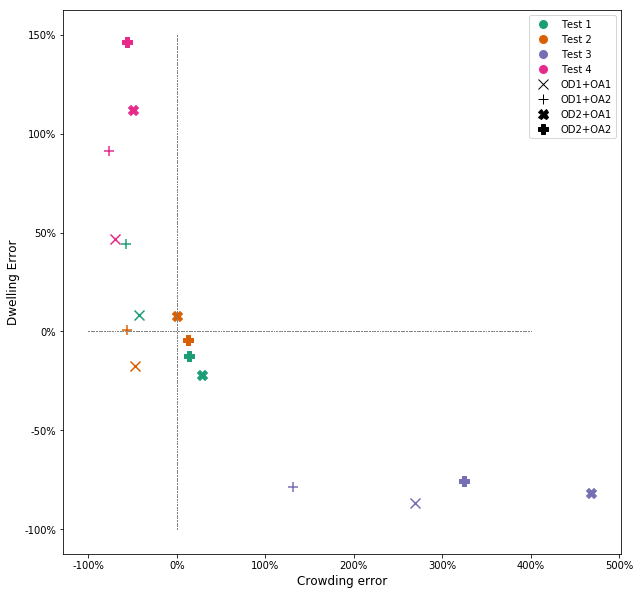

In [331]:
symbols = ["x", "+", "X", "P"]
# colours = ("blue", "orange", "grey", "green")
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_x = 'crowding_error'
plot_y = 'dwelling_error'

for t, test in enumerate(tests):
    test_scores = tests_scores.get(test)
    
    for m, model in enumerate(comb):
        scores = test_scores.get(model)
        x = scores.get(plot_x)
        y = scores.get(plot_y)
        
        axes.plot([0,0],[-1,1.5],'k-', linestyle = ":", lw=1, color = 'grey')
        axes.plot([-1,4],[0,0],'k-', linestyle = ":", lw=1, color = 'grey')
        
        #print('{}: {}: {} = {}, {} = {}'.format(test, model, plot_x, x, plot_y, y))
        
        axes.scatter(x, y, c=colours[t], marker=symbols[m], s=100)
        axes.set_xlabel('Crowding error', size='large')
        axes.set_ylabel('Dwelling Error', size='large')
        vals = axes.get_xticks()
        axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
        vals = axes.get_yticks()
        axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
        legend_elements = legend_elements + [Line2D([0],
                                                    [0],
                                                    marker=mark,
                                                    color='w', markeredgecolor='black',
                                                    label=mmap,markerfacecolor='black',
                                                    markersize=10) for mark, mmap in zip(symbols, comb)]
        
        axes.legend(handles=legend_elements)
        
plt.show()   


In [332]:
fig.savefig('figures/3_4.png', bbox_inches='tight')

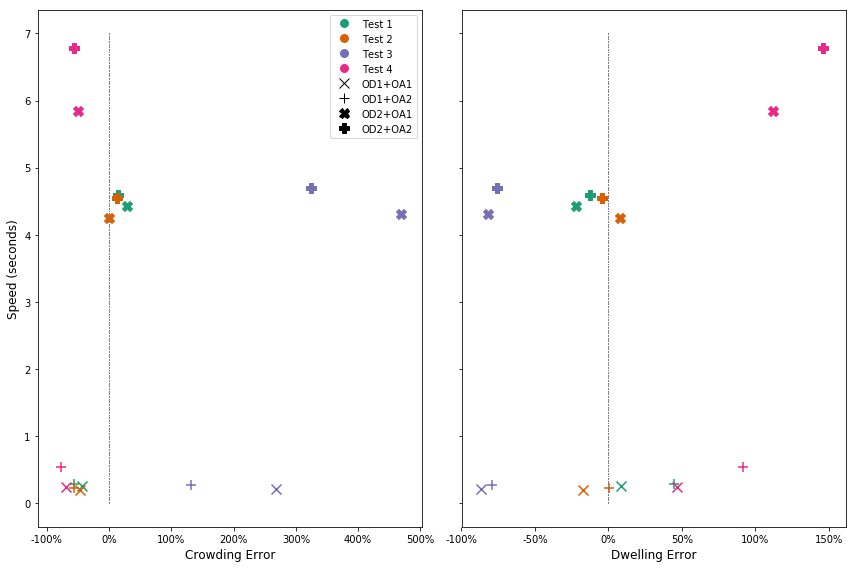

In [336]:
symbols = ["x", "+", "X", "P"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8), sharey=True)
plot_x = ['crowding_error', 'dwelling_error']
plot_x_short = ['Crowding Error', 'Dwelling Error']
plot_y = 'performance_seconds'

for t, test in enumerate(tests):
    test_scores = tests_scores.get(test)
    
    for m, model in enumerate(comb):
        scores = test_scores.get(model)
        
        for i, (item, item_short) in enumerate(zip(plot_x, plot_x_short)):
            x = scores.get(item)
            y = scores.get(plot_y)
            
            axes[i].plot([0,0],[0,7],'k-', linestyle = ":", lw=1, color = 'grey')

            #print('{}: {}: {} = {}, {} = {}'.format(test, model, plot_x, x, plot_y, y))

            axes[i].scatter(x, y, c=colours[t], marker=symbols[m], s=100)
            axes[i].set_xlabel(item_short, size='large')
            
            vals = axes[i].get_xticks()
            axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in vals])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
        legend_elements = legend_elements + [Line2D([0],
                                                    [0],
                                                    marker=mark,
                                                    color='w', markeredgecolor='black',
                                                    label=mmap,markerfacecolor='black',
                                                    markersize=10) for mark, mmap in zip(symbols, comb)]

        axes[0].legend(handles=legend_elements)
        axes[0].set_ylabel('Speed (seconds)', size='large')

fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)
plt.show()   

In [337]:
fig.savefig('figures/3_5.png', bbox_inches='tight')

In [338]:
# calculate realtime results

def get_analysis(input_array):
    realtime_results = np.full((len(input_array), 21), np.inf)  # Results array

    for index, result in enumerate(input_array):
        
        frame, ID, left, top, width, height, conf = result[:7]
        trajectory = 0
        duration = 1 # init
        x = left + (width / 2)
        y = top + (height / 2)
        dx = 0
        dy = 0
        dx_acc = 0
        dy_acc = 0
        distance = 0
        distance_acc = 0
        direction = 0
        x_av = x
        y_av = y
        direction_av = 0
        
        #print('\n\tindex:{} frame:{}'.format(index, frame))

        # look back 3 frames for historic detection
        look_back = 1
        while True:
            h_index = index - look_back
            
            if h_index <= 0:
                break
                
            h_frame, h_ID, h_left, h_top, h_width, h_height, h_conf, h_trajectory, h_duration, h_x, h_y, h_dx, h_dy, h_dx_acc, h_dy_acc, h_distance, h_distance_acc, h_direction, h_x_av, h_y_av, h_direction_av = realtime_results[h_index]
            
            h = frame - h_frame
            
            if h > 3:
                break
                
            #print('\history index:{} frame:{}'.format(h_index, h_frame))

            if h_ID == ID :
                # match found
                #print('match found at frame {} history {}: {}-{}, {}-{}'.format(frame, h, h_ID, ID, h_frame, frame))
                trajectory = 1
                duration = h_duration + h
                dx = x - h_x
                dy = y - h_y
                distance = np.sqrt((dx ** 2) + (dy ** 2))
                x_av = ((h_x_av * h_duration) + dx) / duration
                y_av = ((h_y_av * h_duration) + dy) / duration
                direction = np.arctan2(dy, dx) # right is possitive

                if h_duration > 1:
                    # match with history found
                    dx_acc = h_dx_acc + dx
                    dy_acc = h_dy_acc + dy
                    distance_acc = h_distance_acc + distance
                    direction_av = np.arctan2(dy_acc, dx_acc) # right is possitive
                else:
                    dx_acc = dx
                    dy_acc = dy
                    distance_acc = distance
                    direction_av = direction # right is possitive

                break
            
            look_back += 1
                    
        #print('end of history')

        realtime_results[index] = [frame,
                                   ID,
                                   left,
                                   top,
                                   width,
                                   height,
                                   conf,
                                   trajectory,
                                   duration,
                                   x,
                                   y,
                                   dx,
                                   dy,
                                   dx_acc,
                                   dy_acc,
                                   distance,
                                   distance_acc,
                                   direction,
                                   x_av,
                                   y_av,
                                   direction_av]

    #print('Created results analysis array with shape: {}'.format(realtime_results.shape))
        
    return realtime_results

In [339]:
# Aggregate by ID
def get_ID_aggregation(input_array):
    unique_results = np.zeros((0, input_array.shape[1]))  # Results array
    IDs = []

    for reversed_index, result in enumerate(reversed(input_array)):
        index = len(realtime_results) - reversed_index - 1
        if int(result[1]) not in IDs:
            unique_results = np.append(unique_results, [result], axis=0)
            IDs.append(result[1])
            
    #print('Created unique ids array with shape: {}'.format(unique_results.shape))

    return unique_results

In [340]:
# extract some results
detection_model = detection_models[0]
association_model = association_models[0]
test = tests[1]

path = os.path.join(source, 'tracker_' + test + '_2018-08-10_' + detection_model + '__' + association_model)
results_path = os.path.join(path, '2015-01-03.npy')

results = np.load(results_path)
if verbose:
    print('\t\t> {} detections'.format(len(model_results))) 

In [341]:
def get_trajectory_dict(id_array, results_array):
    trajectory_dict = {}
    for unique in id_array:
        ID = int(unique[1])
        trajectory_x = []
        trajectory_y = []
        for result in results_array:
            if result[1] == ID:
                trajectory_x.append(result[9])
                trajectory_y.append(result[10])
        trajectory_dict[ID] = [trajectory_x, trajectory_y] 
    return trajectory_dict

In [342]:
realtime_results = get_analysis(gts['test1'])
unique_ids_array = get_ID_aggregation(realtime_results)
trajectory_dict = get_trajectory_dict(unique_ids_array, realtime_results)

durations = unique_ids_array[:,8]
distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

headers = ['frame',
           'ID',
           'left',
           'top',
           'width',
           'height',
           'conf',
           'trajectory',
           'duration',
           'x',
           'y',
           'dx',
           'dy',
           'dx_acc',
           'dy_acc',
           'distance',
           'distance_acc',
           'direction',
           'x_av',
           'y_av',
           'direction_av']
    
print(len(durations))
print(len(distances))
pd.DataFrame(unique_ids_array, columns = headers)

14
6


frame    ID        left         top       width      height      conf  \
0   14894.0  14.0  706.038265    0.241492   51.372986  123.699393  0.983675   
1   14891.0  12.0  756.605301   29.870653  136.842041  374.914470  0.995801   
2   14881.0  13.0  437.659836    2.462207   26.294518   54.551525  0.979821   
3   14852.0  11.0  774.308109    0.000000   86.384010  148.336528  0.939808   
4   14851.0  10.0  394.912119    2.447428   20.721703   47.414357  0.887699   
5   14850.0   9.0  397.531099    0.774531   48.712864   55.573995  0.890794   
6   14843.0   8.0    0.000000  157.445776  174.730225  382.554223  0.883588   
7   14841.0   6.0  396.613998    0.000000   17.611427   35.599038  0.925260   
8   14840.0   7.0  535.006828    4.706347   65.623169  124.767527  0.954244   
9   14840.0   5.0   88.276033  171.129565  435.254660  363.371660  0.975803   
10  14818.0   4.0  378.122835    1.736228   21.135235   49.547179  0.805538   
11  14818.0   1.0  429.525232    0.314464   28.704128   46.591856  0.901146   
12  14817.0   2.0  518.612080    0.370646   67.697868  124.933724  0.662038   
13  14809.0   0.0  633.252125    0.000000   29.149246   38.528638  0.574003   

    trajectory  duration           x      ...               dx         dy  \
0          1.0      14.0  731.724758      ...       -72.218399 -20.027190   
1          1.0      12.0  825.026321      ...        -2.944393   6.571791   
2          0.0       1.0  450.807095      ...         0.000000   0.000000   
3          0.0       1.0  817.500114      ...         0.000000   0.000000   
4          0.0       1.0  405.272970      ...         0.000000   0.000000   
5          1.0       3.0  421.887531      ...      -188.389893 -51.223423   
6          0.0       1.0   87.365112      ...         0.000000   0.000000   
7          1.0       2.0  405.419712      ...      -136.667519 -54.423904   
8          0.0       1.0  567.818413      ...         0.000000   0.000000   
9          0.0       1.0  305.903363      ...         0.000000   0.000000   
10         0.0       1.0  388.690453      ...         0.000000   0.000000   
11         1.0       2.0  443.877296      ...        -3.927240 -47.962538   
12         0.0       1.0  552.461014      ...         0.000000   0.000000   
13         1.0       2.0  647.826748      ...        45.443630 -25.811650   

        dx_acc      dy_acc    distance  distance_acc  direction        x_av  \
0   -57.067451 -248.177308   74.943882    411.784580  -2.871076   52.266054   
1   346.812444  152.876949    7.201242    470.978546   1.992015   68.752193   
2     0.000000    0.000000    0.000000      0.000000   0.000000  450.807095   
3     0.000000    0.000000    0.000000      0.000000   0.000000  817.500114   
4     0.000000    0.000000    0.000000      0.000000   0.000000  405.272970   
5   287.011374 -153.508646  195.229585    681.509989  -2.876110  140.629177   
6     0.000000    0.000000    0.000000      0.000000   0.000000   87.365112   
7  -136.667519  -54.423904  147.105309    147.105309  -2.762621  202.709856   
8     0.000000    0.000000    0.000000      0.000000   0.000000  567.818413   
9     0.000000    0.000000    0.000000      0.000000   0.000000  305.903363   
10    0.000000    0.000000    0.000000      0.000000   0.000000  388.690453   
11   -3.927240  -47.962538   48.123053     48.123053  -1.652495  221.938648   
12    0.000000    0.000000    0.000000      0.000000   0.000000  552.461014   
13   45.443630  -25.811650   52.262461     52.262461  -0.516552  323.913374   

          y_av  direction_av  
0     4.435085     -1.796814  
1    18.110657      0.415182  
2    29.737970      0.000000  
3    74.168264      0.000000  
4    26.154607      0.000000  
5     9.520509     -0.491139  
6   348.722888      0.000000  
7     8.899760     -2.762621  
8    67.090111      0.000000  
9   352.815395      0.000000  
10   26.509818      0.000000  
11   11.805196     -1.652495  
12   62.837508      0.000000  
13    9.632160     -0.516552  

[14 rows x 2

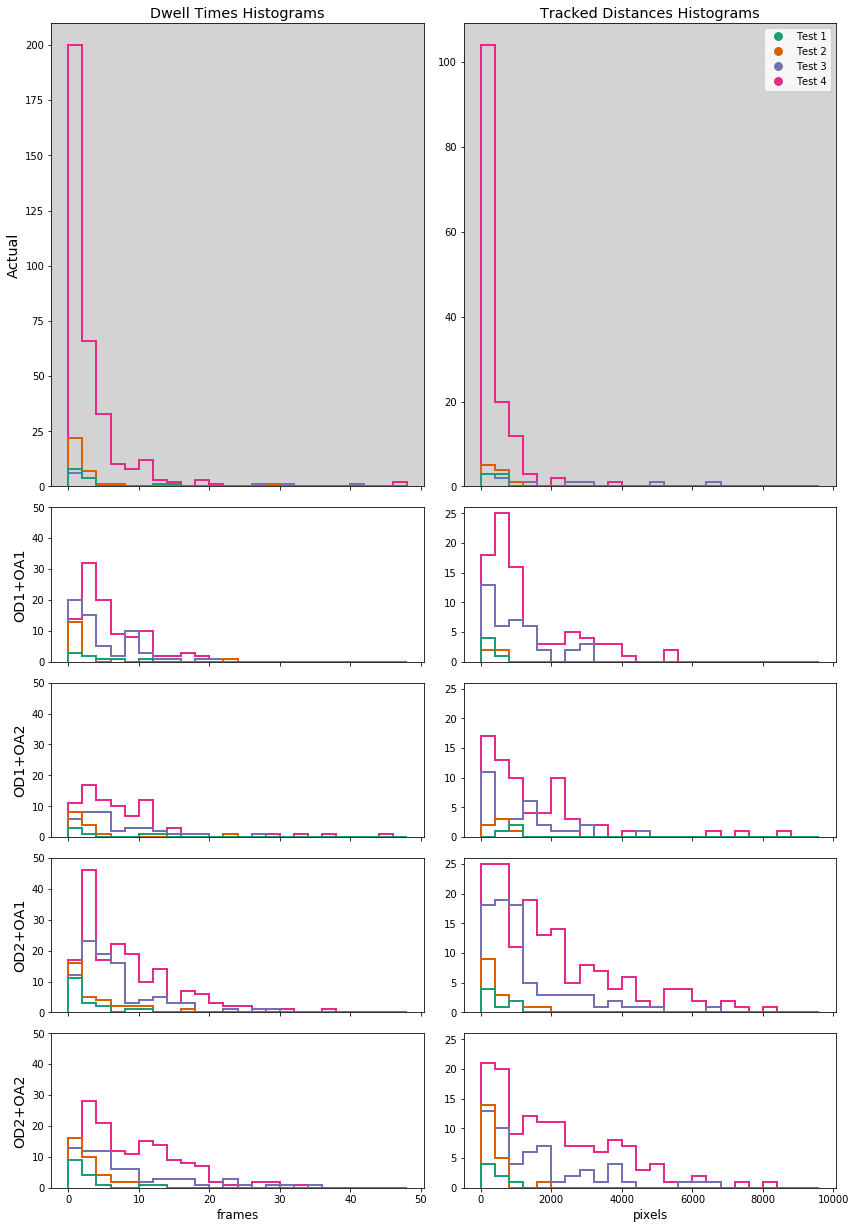

In [346]:
# Histogram for unique individuals
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,17), sharex='col', gridspec_kw = {'height_ratios':[3,1,1,1,1]})

plots = ['Dwell Times Histograms', 'Tracked Distances Histograms']

for t, test in enumerate(reversed(tests)):
    gt_results = gts.get(test)

    realtime_results = get_analysis(gt_results)
    unique_ids_array = get_ID_aggregation(realtime_results)
    #trajectory_dict = get_trajectory_dict(unique_ids_array, realtime_results)

    durations = unique_ids_array[:,8]
    distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

    axes[0,0].hist(durations, alpha=1, color = colours_r[t], bins=list(np.arange(0,50,2)), histtype='step', lw=2)
    axes[0,1].hist(distances, alpha=1, color = colours_r[t], bins=list(range(0,10000,400)), histtype='step', lw=2)
    
    axes[0,0].set_ylabel('Actual', size='x-large')
    
    axes[0,0].set_facecolor('lightgrey')
    axes[0,1].set_facecolor('lightgrey') 

for t, test in enumerate(reversed(tests)):
    test_results = tests_results.get(test)
    
    for row, model in enumerate(comb):
        results = test_results.get(model)
        
        realtime_results = get_analysis(results)
        unique_ids_array = get_ID_aggregation(realtime_results)
        #trajectory_dict = get_trajectory_dict(unique_ids_array, realtime_results)
        
        durations = unique_ids_array[:,8]
        distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

        axes[row + 1,0].hist(durations, alpha=1, color = colours_r[t], bins=list(np.arange(0,50,2)), histtype='step', lw=2)
        axes[row + 1,1].hist(distances, alpha=1, color = colours_r[t], bins=list(range(0,10000,400)), histtype='step', lw=2)
        
        axes[row + 1,0].set_ylim(0, 50)
#         axes[row + 1,0].set_xlim(0, 12)
        axes[row + 1,1].set_ylim(0, 26)
#         axes[row + 1,1].set_xlim(0, 2000)
        
        axes[row + 1,0].set_ylabel(comb[row], size='x-large')

legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
axes[0,1].legend(handles=legend_elements)
axes[4,0].set_xlabel('frames', size='large')
axes[4,1].set_xlabel('pixels', size='large')
        
pad = 5
for ax, text in zip(axes[0], plots):
    ax.annotate(text, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)
plt.show() 

In [347]:
fig.savefig('figures/3_10.png', bbox_inches='tight')

In [358]:
# Create timeline results for 

timeline_tests_results = {}

for t, test in enumerate(tests):
    test_results = tests_results.get(test)
    
    gt_results = gts.get(test)
    realtime_actual = get_analysis(gt_results)
    
    gt_timeline_crowding = {}
    gt_timeline_dwelling = {}
    gt_timeline_distance = {}
        
    min_frame_counter = int(min(gt_results[:,0]))
    #frame_counter_max = max(max(results[:,0]), max(gt_results[:,0]))
    frame_counter = min_frame_counter
    frame_counter_max = frame_counter + 99
    
    timeline_models_results = {}
    
    while True:
        crowding_counter = 0
        dwelling_counter = 0
        distance_counter = 0
        for result in realtime_actual:
            if result[0] == frame_counter:
                crowding_counter += 1
                dwelling_counter += result[8]
                distance_counter += result[16]

        gt_timeline_crowding[frame_counter] = crowding_counter
        gt_timeline_dwelling[frame_counter] = dwelling_counter
        gt_timeline_distance[frame_counter] = distance_counter

        if frame_counter == frame_counter_max:
            break
        frame_counter += 1
            
    gt_timeline_results = {'Crowding': gt_timeline_crowding, 'Dwelling': gt_timeline_dwelling, 'Distance': gt_timeline_distance}
    timeline_models_results['Actual'] = gt_timeline_results
    
    for row, model in enumerate(comb):
           
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        
        timeline_crowding = {}
        timeline_dwelling = {}
        timeline_distance = {}
        
        frame_counter = min_frame_counter
        
        while True:
            crowding_counter = 0
            dwelling_counter = 0
            distance_counter = 0
            for result in realtime_results:
                if result[0] == frame_counter:
                    crowding_counter += 1
                    dwelling_counter += result[8]
                    distance_counter += result[16]
                    
            timeline_crowding[frame_counter] = crowding_counter
            timeline_dwelling[frame_counter] = dwelling_counter
            timeline_distance[frame_counter] = distance_counter
            
            if frame_counter == frame_counter_max:
                break
            frame_counter += 1
            
        model_timeline_results = {'Crowding': timeline_crowding, 'Dwelling': timeline_dwelling, 'Distance': timeline_distance}
        timeline_models_results[model] = model_timeline_results
        
    timeline_tests_results[test] = timeline_models_results   
        

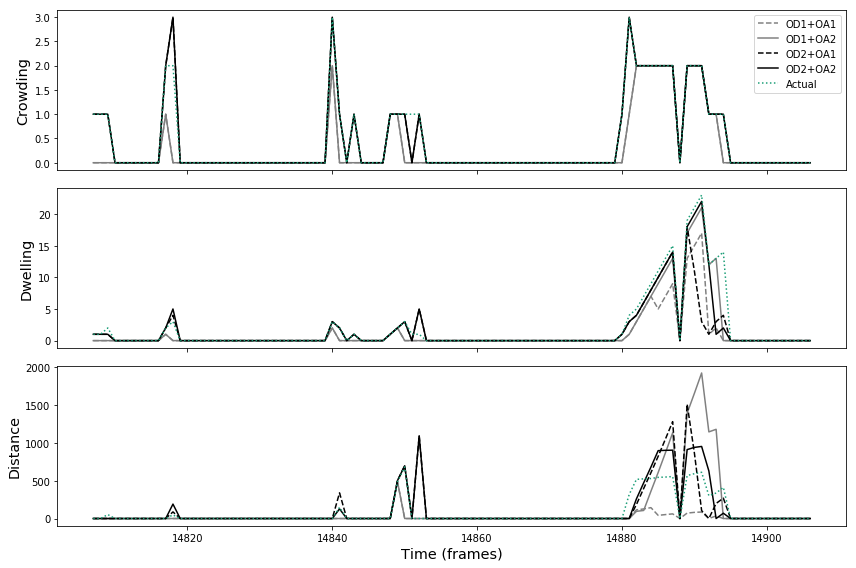

In [360]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#1b9e77']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test1'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()

fig.tight_layout()
plt.show()


In [361]:
fig.savefig('figures/3_6test1.png', bbox_inches='tight')

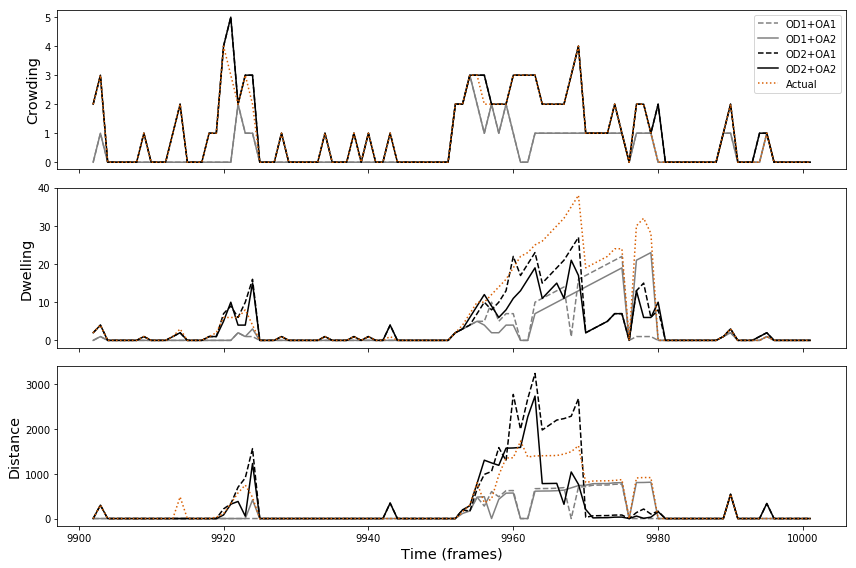

In [362]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#d95f02']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test2'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [363]:
fig.savefig('figures/3_6test2.png', bbox_inches='tight')

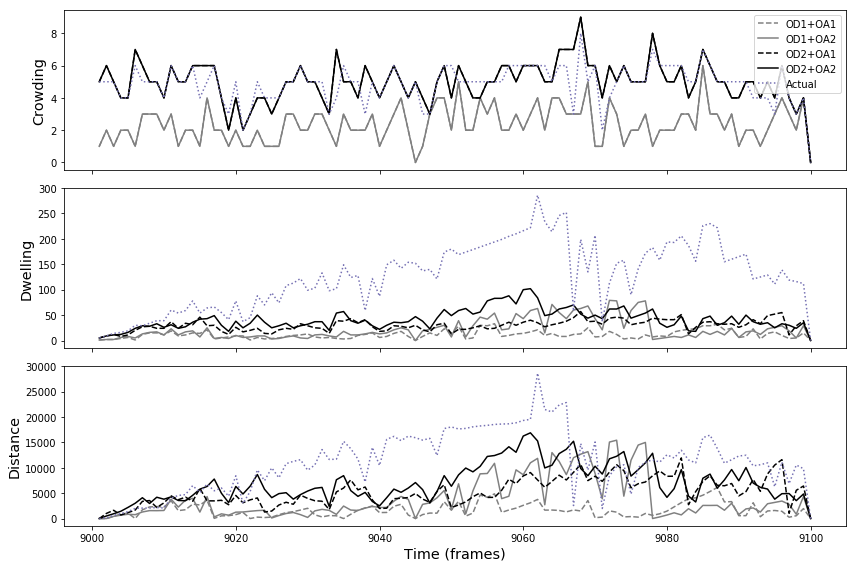

In [364]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#7570b3']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test3'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [365]:
fig.savefig('figures/3_6test3.png', bbox_inches='tight')

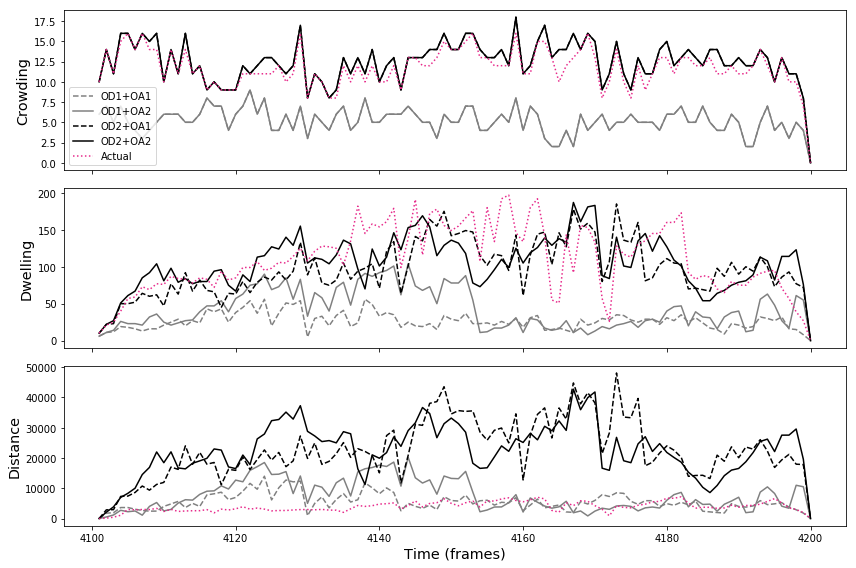

In [366]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#e7298a']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test4'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [367]:
fig.savefig('figures/3_6test4.png', bbox_inches='tight')

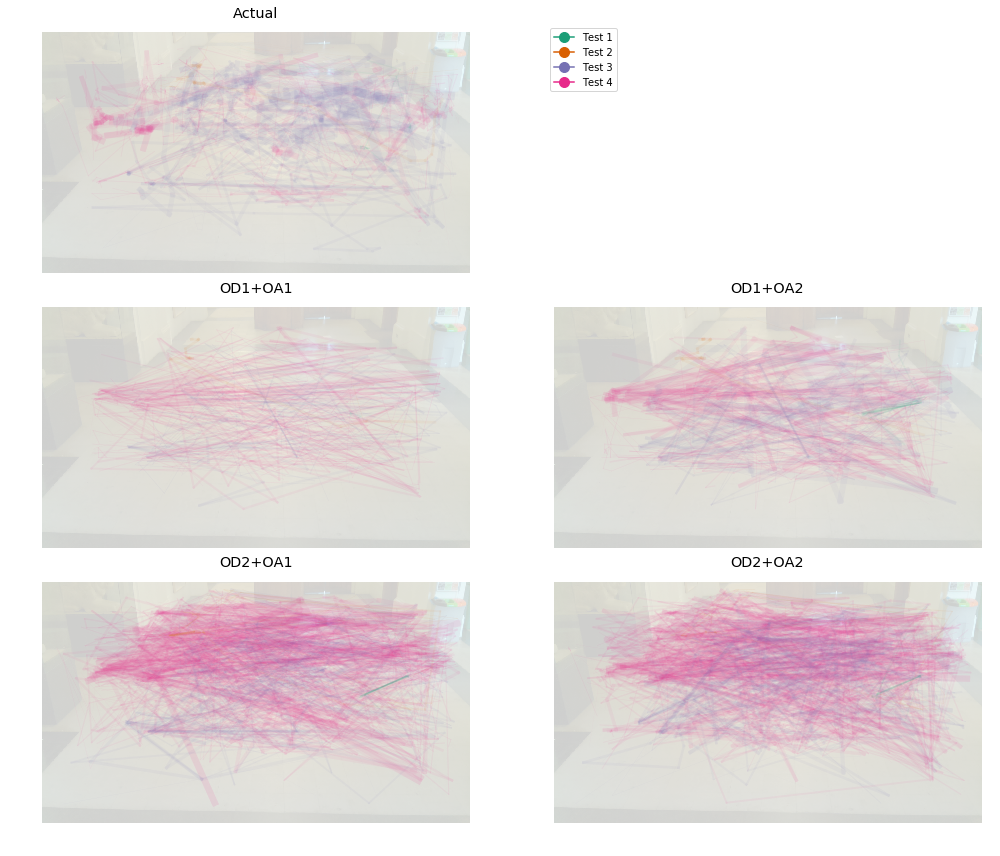

In [369]:
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

titles = ['Trajectories']

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(14, 12))
axes[0,0].imshow(frame)
for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        axes[row+1,col].imshow(frame)

for t, test in enumerate(tests_r):
    test_results = tests_results.get(test)
    gt_results = gts.get(test)
    gt_realtime_results = get_analysis(gt_results)
    gt_unique_detections = get_ID_aggregation(gt_realtime_results)
    gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
    

    for unique in gt_unique_detections:
        ID = unique[1]
        duration = unique[8]
        trajectory_x, trajectory_y = gt_trajectory_dict.get(ID)
        for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
            axes[0,0].plot([x1,x2], [y1,y2], alpha=0.05, c=colours_r[t], linewidth=duration/10, label='actual')
            axes[0,0].set_title('Actual', size='x-large')
            axes[0,0].axis('off')
            axes[0,1].axis('off')
    
    for row, odm in enumerate(odms):
        for col, oam in enumerate(oams):
            model = odm + '+' + oam
            results = test_results.get(model)
            realtime_results = get_analysis(results)
            unique_detections = get_ID_aggregation(realtime_results)
            trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)

            for unique in unique_detections:
                ID = unique[1]
                duration = unique[8]
                trajectory_x, trajectory_y = trajectory_dict.get(ID)
                for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
                    axes[row+1,col].plot([x1,x2], [y1,y2], alpha=0.05, c=colours_r[t], linewidth=duration/8, label=test)
                    axes[row+1, col].set_title(model, size='x-large')
                    axes[row+1, col].axis('off')

    legend_elements = [Line2D([0], [0], marker='o', color=c, label=cmap,
                              markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]

    axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.15, hspace=0.06)

plt.show()

In [370]:
fig.savefig('figures/3_20.png', bbox_inches='tight')

In [371]:
def create_grid(image, step):
    h, w = image.shape[:2]
    h_steps = int(h / step)
    h_buffer = int((h - ((h_steps - 1) * step)) / 2)
    w_steps = int(w / step)
    w_buffer = int((w - ((w_steps - 1) * step)) / 2)
    
    grid = []
    
    for row in range(h_steps):
        for col in range(w_steps):
            y = h_buffer + (row * step)
            x = w_buffer + (col * step)
            grid.append([x, y])
    return grid
            
    

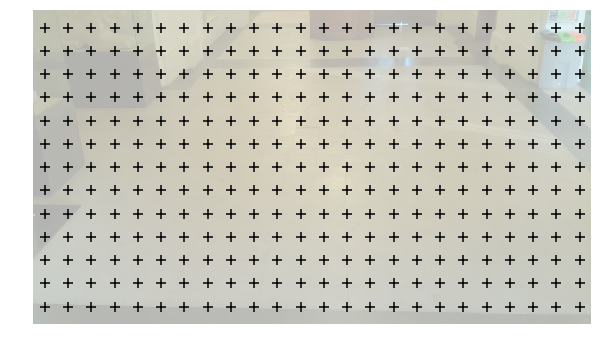

In [372]:
frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = create_grid(frame, 40)
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True, figsize=(10, 6))
axes.imshow(frame)
for point in grid:  
    axes.scatter(point[0], point[1], c='black', marker='+', s=100)
    axes.axis('off')

In [373]:
fig.savefig('figures/3_20grid.png', bbox_inches='tight')

In [374]:
def dist_to_point(x1,y1, x2,y2):
    dx = x2-x1
    dy = y2-y1
    dist = math.sqrt(dx*dx + dy*dy)

    return dist
    

In [375]:
def dist_to_line(x1,y1, x2,y2, x3,y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1
    
    if px == 0 and py == 0:
        dist = dist_to_point(x1,y1, x3, y3)
        return dist

    something = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(something)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    dist = math.sqrt(dx*dx + dy*dy)

    return dist

In [376]:
def get_kernel_results(grid, max_kernel_size, unique_detections, trajectory_dict):
    g_trajectory = []
    g_distance = []
    g_dx = []
    g_dy = []

    for point in grid:
        p_trajectory = 0
        p_distance = 0
        p_dx = 0
        p_dy = 0

        for unique in unique_detections:
            ID = unique[1]
            trajectory = unique[7]
            x, y = unique[9], unique[10]

            if not trajectory:
                dist = dist_to_point(x, y, point[0], point[1])
                if dist < max_kernel_size:
                    p_trajectory += 1

            else:  
                distance = unique[15]
                dx = unique[11]
                dy = unique[12]
                trajectory_x, trajectory_y = trajectory_dict.get(ID)
                for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
                    dist = dist_to_line(x1, y1, x2, y2, point[0], point[1])
                    if dist < max_kernel_size:
                        p_trajectory += 1
                        p_distance += distance
                        p_dx = dx
                        p_dy = dy

        g_trajectory.append(p_trajectory)
        g_distance.append(p_distance)
        g_dx.append(p_dx)
        g_dy.append(p_dy)

#     # norm
#     g_trajectory = [float(i)/max(g_trajectory) for i in g_trajectory]
#     g_duration = [float(i)/max(g_duration) for i in g_duration]
#     g_dx = [float(i)/max(g_dx) for i in g_dx]
#     g_dy = [float(i)/max(g_dy) for i in g_dy]
    
    return g_trajectory, g_distance, g_dx, g_dy
    

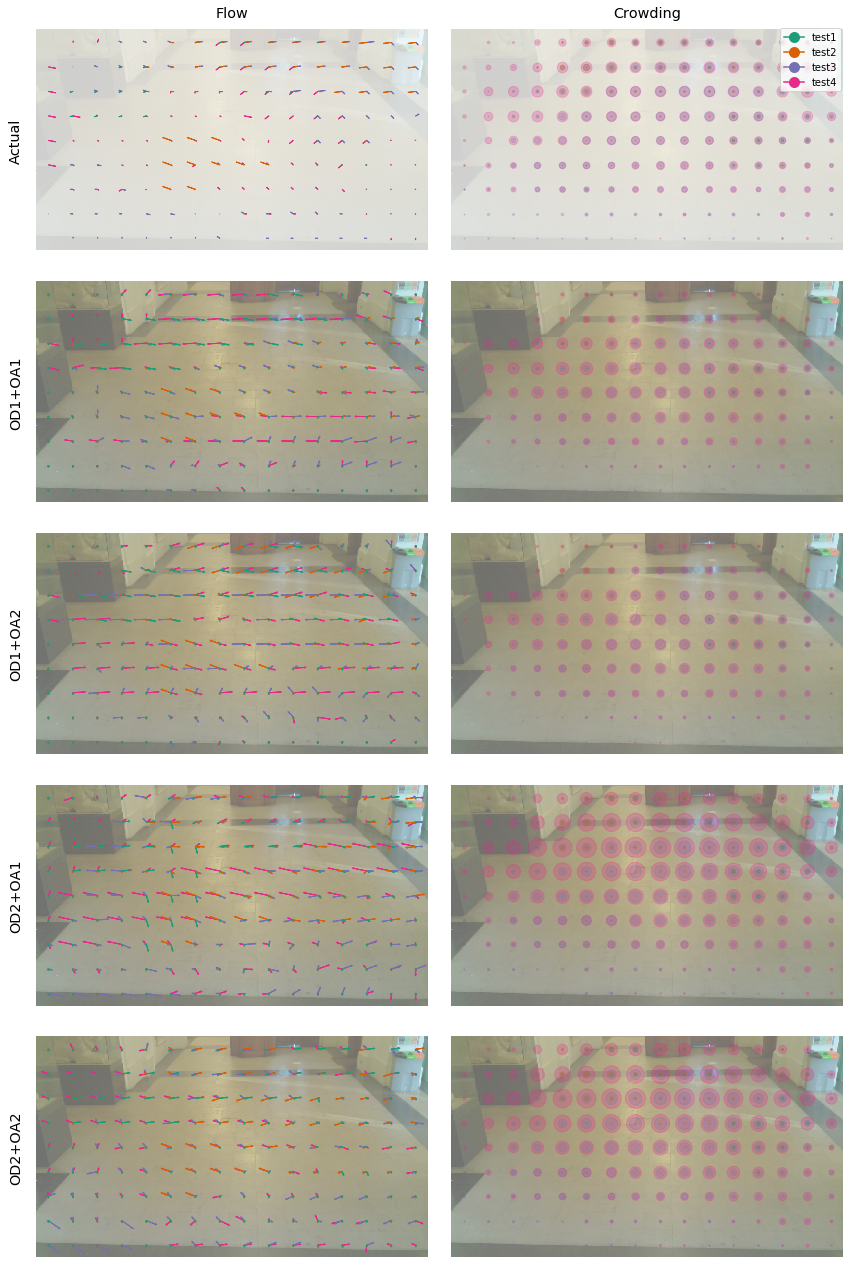

In [377]:
step_size = 60
max_kernel_size = 75
correction = 25

comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=5, ncols=2, sharey=True, sharex=True, figsize=(12, 18))

axes[0,0].imshow(frame)
axes[0,1].imshow(frame)

for t, test in enumerate(tests_r[:]):
    test_results = tests_results.get(test)
    
    gt_results = gts.get(test)
    gt_realtime_results = get_analysis(gt_results)
    gt_unique_detections = get_ID_aggregation(gt_realtime_results)
    gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
    g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                              max_kernel_size,
                                                              gt_unique_detections,
                                                              gt_trajectory_dict)
    
    
    for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):
        
        axes[0,0].arrow(point[0], point[1],
                        p_dx/correction,
                        -p_dy/correction,
                        edgecolor=colours_r[t])
        
        axes[0,1].scatter(point[0], point[1],
                          s=p_trajectory,
                          c=colours_r[t],
                          alpha=.25,
                          label = tests_r[t])
        
        axes[0,0].set_title('Flow', size='x-large')
        axes[0,1].set_title('Crowding', size='x-large')
        axes[0,0].axis('off')
        axes[0,1].axis('off')
        
    for row, model in enumerate(comb):
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        unique_detections = get_ID_aggregation(realtime_results)
        trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,0].imshow(frame)
        axes[row+1,1].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):
            
            axes[row+1,0].arrow(point[0], point[1],
                                  p_dx/correction,
                                  -p_dy/correction,
                                  edgecolor=colours_r[t],
                                 head_width=3)
            
            axes[row+1,1].scatter(point[0], point[1],
                                    s=p_trajectory,
                                    c=colours_r[t],
                                    alpha=.25,
                                    label = tests_r[t])

            axes[row+1,0].axis('off')
            axes[row+1,1].axis('off')

legend_elements = [Line2D([0],
                          [0],
                          marker='o',
                          color=c,
                          label=cmap,
                          markerfacecolor=c,
                          markersize=10) for c, cmap in zip(colours, tests)]

pad = 10
rows = ['Actual'] + comb
for ax, r in zip(axes[:,0], rows):
    ax.annotate(r, xy=(0, 0.5), xytext=(- pad, 0),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)

axes[0,1].legend(handles=legend_elements, loc=1)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [379]:
fig.savefig('figures/3_7.png', bbox_inches='tight')

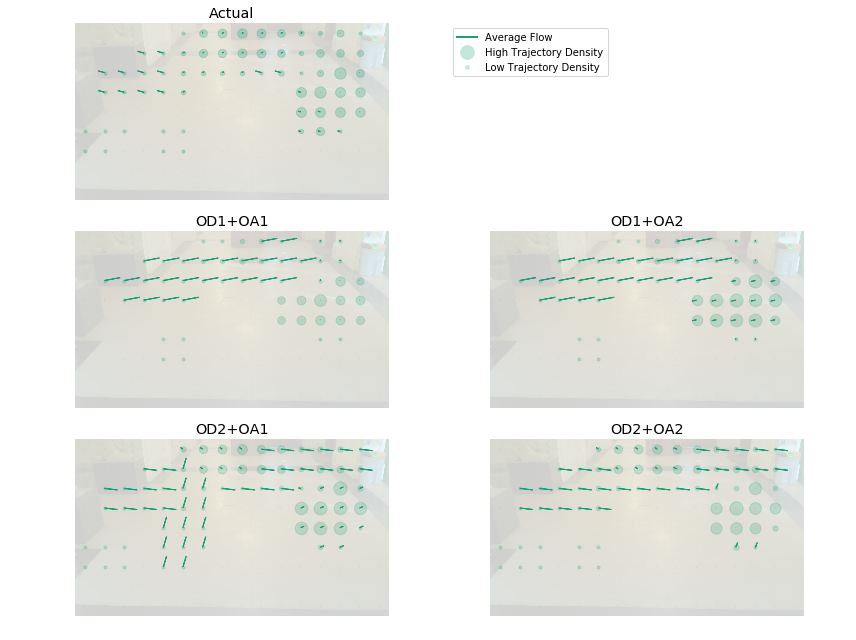

In [400]:
step_size = 60
max_kernel_size = 75
correction = 10

t = 0
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 9))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results = get_analysis(gt_results)
gt_unique_detections = get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t])

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*10,
                      c=colours[t],
                      alpha=.25,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        unique_detections = get_ID_aggregation(realtime_results)
        trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t])

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*10,
                                    c=colours[t],
                                    alpha=.2,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [401]:
fig.savefig('figures/3_21test1.png', bbox_inches='tight')

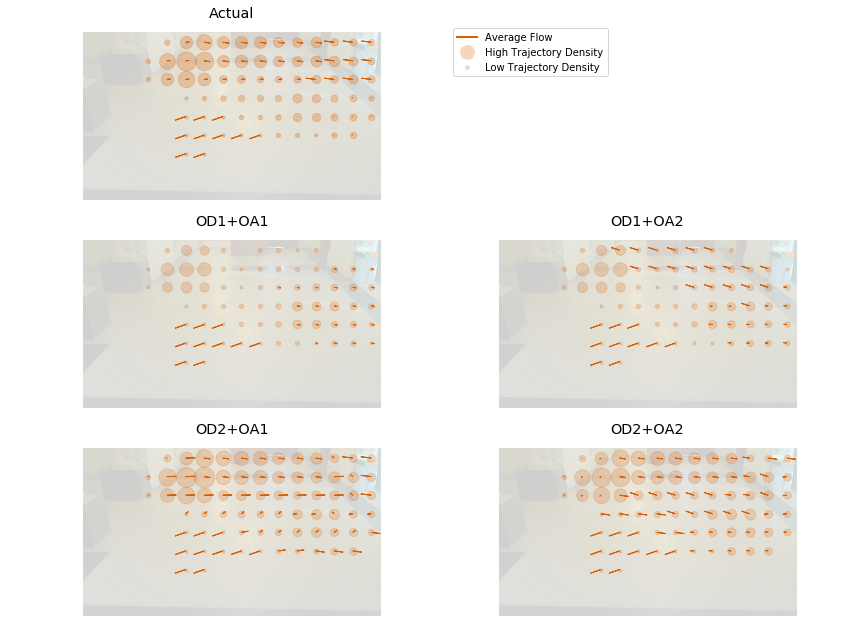

In [402]:
step_size = 60
max_kernel_size = 75
correction = 15

t = 1
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 9))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results = get_analysis(gt_results)
gt_unique_detections = get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t])

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*10,
                      c=colours[t],
                      alpha=.25,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        unique_detections = get_ID_aggregation(realtime_results)
        trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t])

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*10,
                                    c=colours[t],
                                    alpha=.2,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [403]:
fig.savefig('figures/3_21test2.png', bbox_inches='tight')

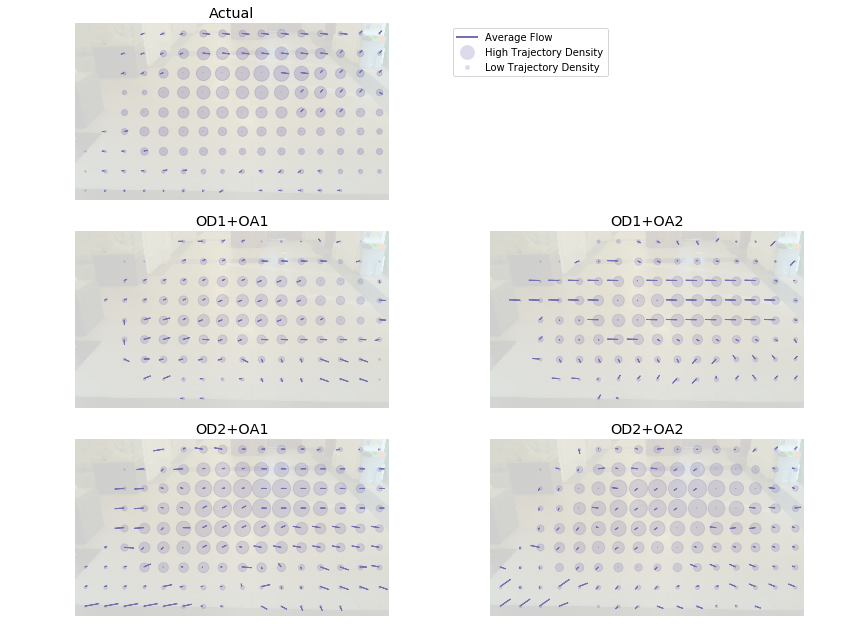

In [396]:
step_size = 60
max_kernel_size = 75
correction = 20

t = 2
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 9))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results = get_analysis(gt_results)
gt_unique_detections = get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t])

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*2,
                      c=colours[t],
                      alpha=.25,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        unique_detections = get_ID_aggregation(realtime_results)
        trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t])

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*2,
                                    c=colours[t],
                                    alpha=.2,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [397]:
fig.savefig('figures/3_21test3.png', bbox_inches='tight')

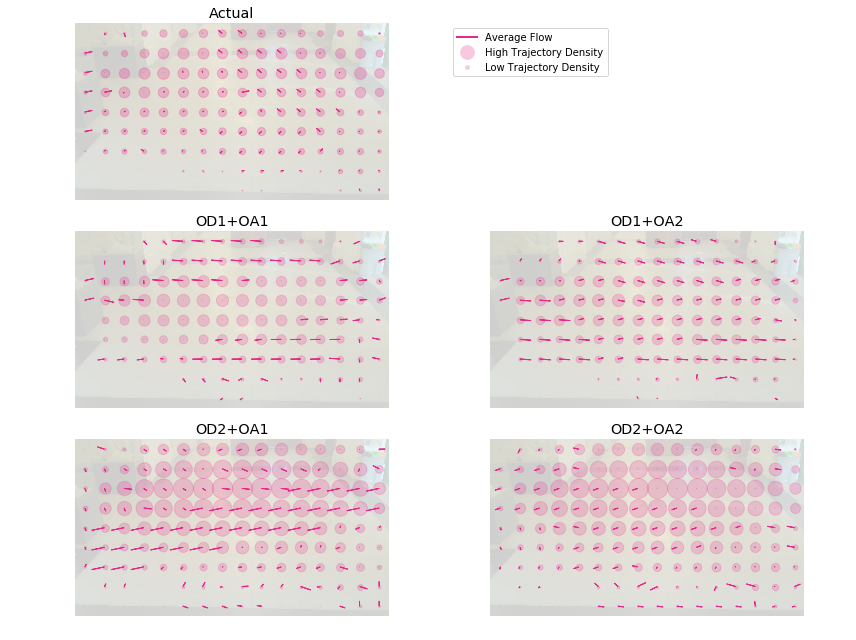

In [398]:
step_size = 60
max_kernel_size = 75
correction = 20

t = 3
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 9))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results = get_analysis(gt_results)
gt_unique_detections = get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t])

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory,
                      c=colours[t],
                      alpha=.25,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results = get_analysis(results)
        unique_detections = get_ID_aggregation(realtime_results)
        trajectory_dict = get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t])

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory,
                                    c=colours[t],
                                    alpha=.2,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.25, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [399]:
fig.savefig('figures/3_21test4.png', bbox_inches='tight')